In [56]:
import jax

import jax.numpy as np
import jax.scipy as sp

import paragami

import matplotlib.pyplot as plt
%matplotlib inline

from bnpmodeling_runjingdev import log_phi_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

from structure_vb_lib import structure_model_lib

import re

In [57]:
import numpy as onp 
onp.random.seed(53453)

# File paths

In [58]:
data_file='../data/phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'
out_filename='huang2011_fit'
out_folder='../fits/hgdp_fits/'

# data_file = '../data/huang2011_sub_nobs25_nloci75.npz'
# out_filename = 'huang2011_fit_sub'
# out_folder = '../fits/tmp/'


In [59]:
alpha0 = 6.0

init_fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'
lr_file = out_folder + out_filename + '_alpha' + str(alpha0) + '_lrderivatives.npz'

# Some helper functions to load and plot posterior statistics

In [73]:
def load_e_num_clusters_vec(perturbation): 
    match_crit = out_filename + '_' + perturbation + '\d+_poststats.npz'
    ps_files = [f for f in os.listdir(out_folder) if re.match(match_crit, f)]
    assert len(ps_files) > 0
    
    def load_key(key): 
        vec = onp.zeros(len(ps_files))
        
        for i in range(len(ps_files)): 
            post_stats = np.load(out_folder + ps_files[i])
            vec[i] = post_stats[key].squeeze()
            
        return vec

    # load epsilons
    epsilon_vec = load_key('epsilon')
    
    # permutation to put epsilons in order
    indx = onp.argsort(epsilon_vec)
    
    # get expected number of clusters under refit
    nc_refit_vec = load_key('e_n_clusters_refit')[indx] # number of in-sample clusters (thresholded)
    npc_refit_vec = load_key('e_n_pred_clusters_refit')[indx] # num. predictive clusters
    npct_refit_vec = load_key('e_n_pred_clusters_refit_thresh')[indx] # pred. clusters thresholded
    
    # get expected number of clusters under lr
    nc_lr_vec = load_key('e_n_clusters_lr')[indx]
    npc_lr_vec = load_key('e_n_pred_clusters_lr')[indx]
    npct_lr_vec = load_key('e_n_pred_clusters_lr_thresh')[indx]
    
    return nc_refit_vec, npc_refit_vec, npct_refit_vec,\
            nc_lr_vec, npc_lr_vec, npct_lr_vec,\
                epsilon_vec[indx]

In [74]:
def plot_e_num_clusters(refit_vec, lr_vec, epsilon_vec, ax): 
    ax.plot(epsilon_vec, 
           refit_vec, 
           'o-', 
           color = '#d95f02',
           label = 'refit')

    ax.plot(epsilon_vec,
               lr_vec, 
               'o-', 
               color = 
               '#1b9e77',
               label = 'lr')
    
    ax.set_xlabel('epsilon')

In [81]:
def plot_e_num_clusters_for_perturbation(perturbation): 
    fig, ax = plt.subplots(1, 3, figsize = (15, 4)) 

    nc_refit_vec, npc_refit_vec, npct_refit_vec,\
        nc_lr_vec, npc_lr_vec, npct_lr_vec,\
            epsilon_vec = load_e_num_clusters_vec(perturbation)

    plot_e_num_clusters(refit_vec = nc_refit_vec, 
                        lr_vec = nc_lr_vec, 
                        epsilon_vec = epsilon_vec, 
                        ax = ax[0])


    plot_e_num_clusters(refit_vec = npc_refit_vec, 
                        lr_vec = npc_lr_vec, 
                        epsilon_vec = epsilon_vec, 
                        ax = ax[1])
    
    plot_e_num_clusters(refit_vec = npct_refit_vec, 
                        lr_vec = npct_lr_vec, 
                        epsilon_vec = epsilon_vec, 
                        ax = ax[2])

# Function to plot the perturbation

In [82]:
lr_data = np.load(lr_file)
logit_v_grid = np.array(lr_data['logit_v_grid'])
influence_grid = np.array(lr_data['influence_grid'])
alpha0 = lr_data['alpha0']

def plot_perturbation(perturbation): 
    
    if 'sigmoidal' in perturbation: 
        delta = 5.0
    else: 
        delta = 1.0
    

    # get functional perturbation objectives
    # a lot of arguments are "none" because we just 
    # need the bare minimum to make plots
    f_obj_all = log_phi_lib.LogPhiPerturbations(vb_params_paragami = None, 
                                                 alpha0 = alpha0,
                                                 gh_loc = None, 
                                                 gh_weights = None,
                                                 logit_v_grid = logit_v_grid, 
                                                 influence_grid = influence_grid, 
                                                 delta = delta,
                                                 stick_key = 'ind_admix_params')

    f_obj = getattr(f_obj_all, 'f_obj_' + perturbation)
    
    # compute the prior perturbations
    prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = alpha0,
                                    log_phi = f_obj.log_phi, 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)
    
    prior_perturbation.plot_perturbation();

# Plot results

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.677581e-03
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.750940e-01
  warnings.warn(


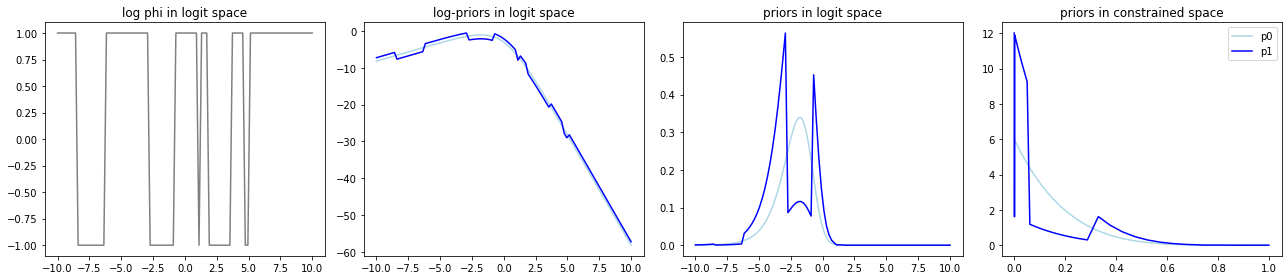

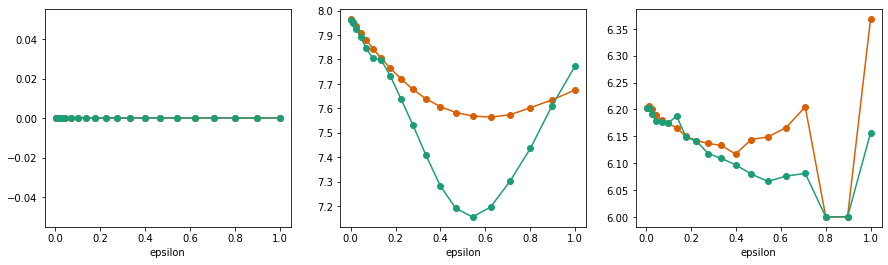

In [108]:
perturbation = 'worst_case'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.388126e-08
  warnings.warn(


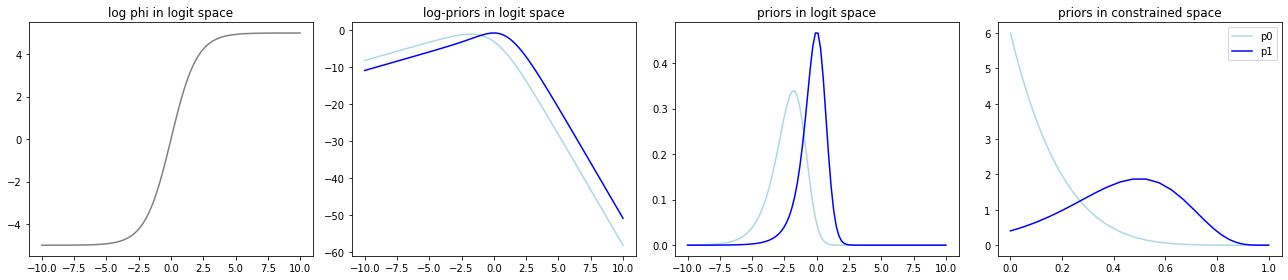

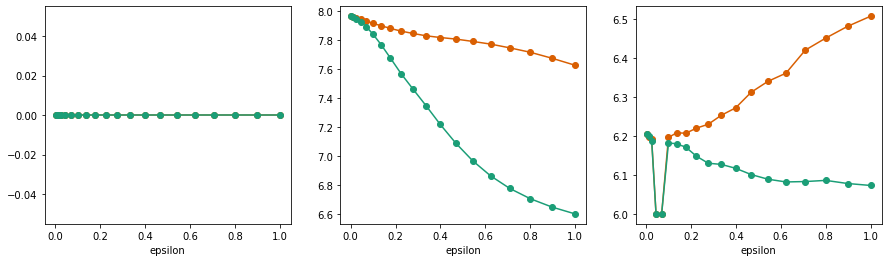

In [109]:
perturbation = 'sigmoidal'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)

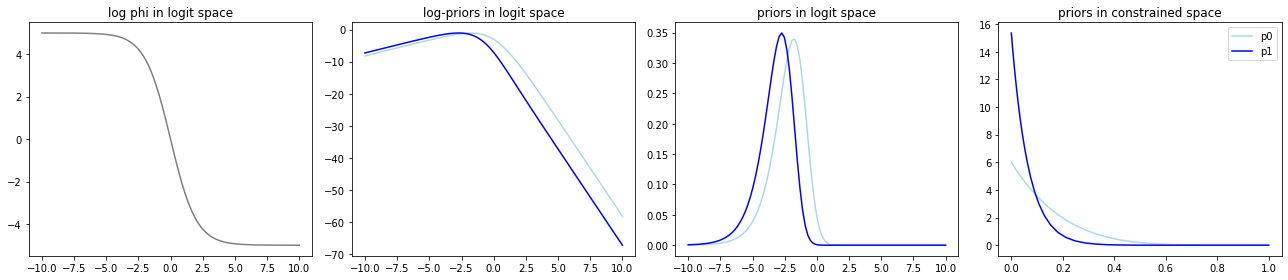

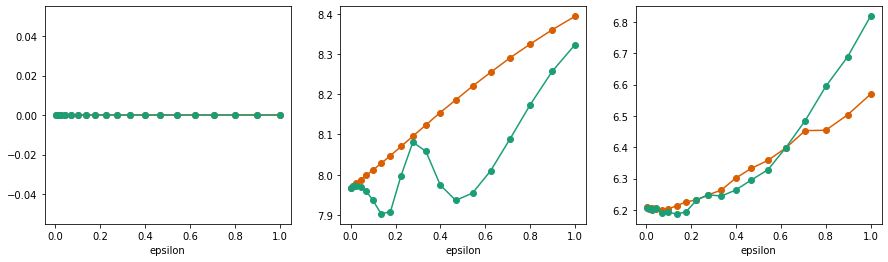

In [110]:
perturbation = 'sigmoidal_neg'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)

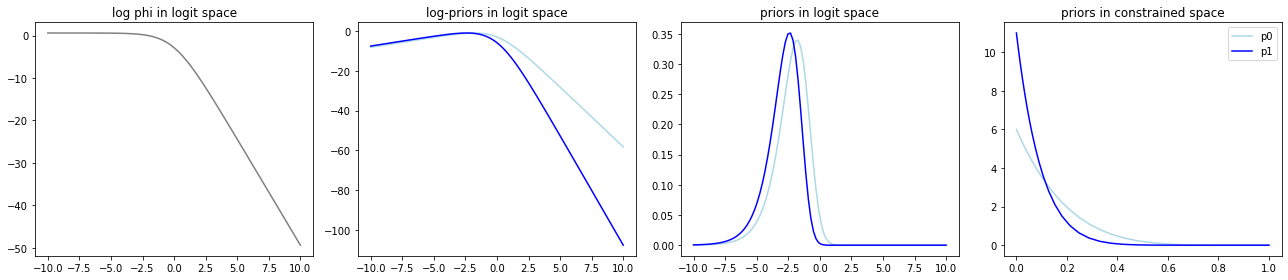

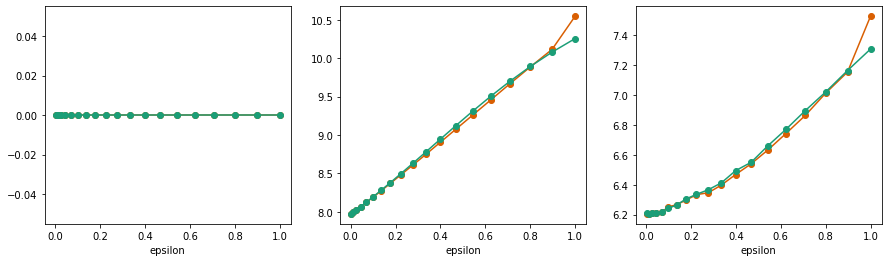

In [111]:
perturbation = 'alpha_pert_pos'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)

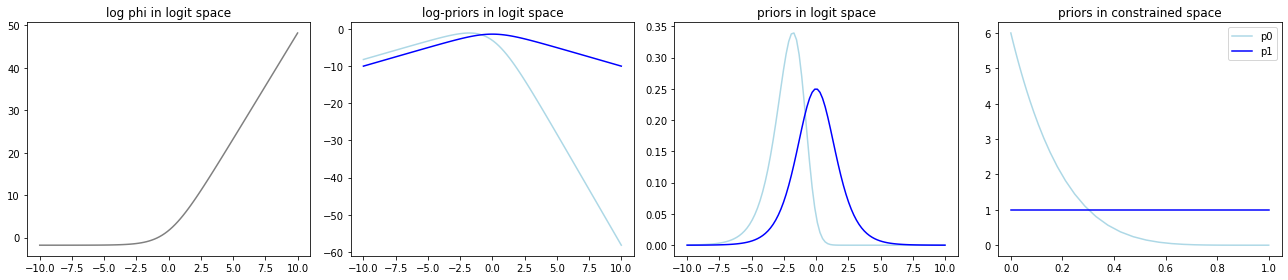

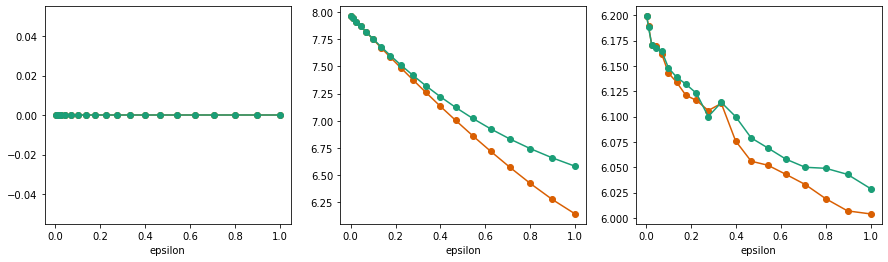

In [112]:
perturbation = 'alpha_pert_neg'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.091946e-08
  warnings.warn(


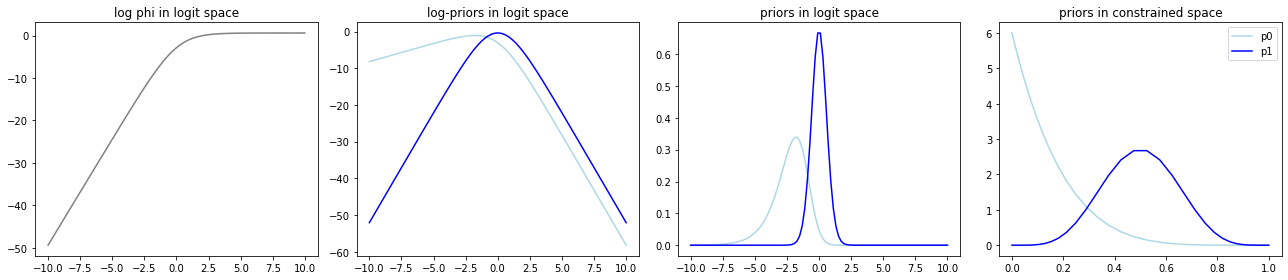

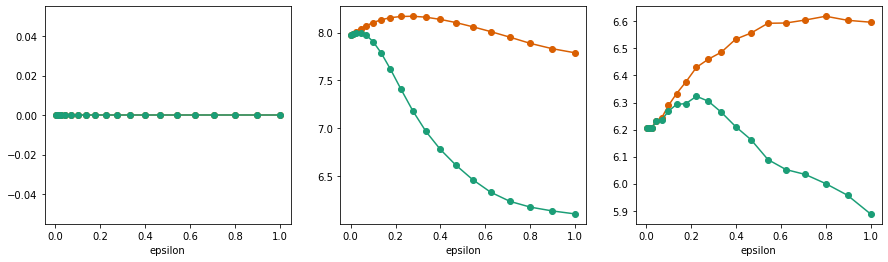

In [113]:
perturbation = 'alpha_pert_pos_xflip'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.669512e+12
  warnings.warn(


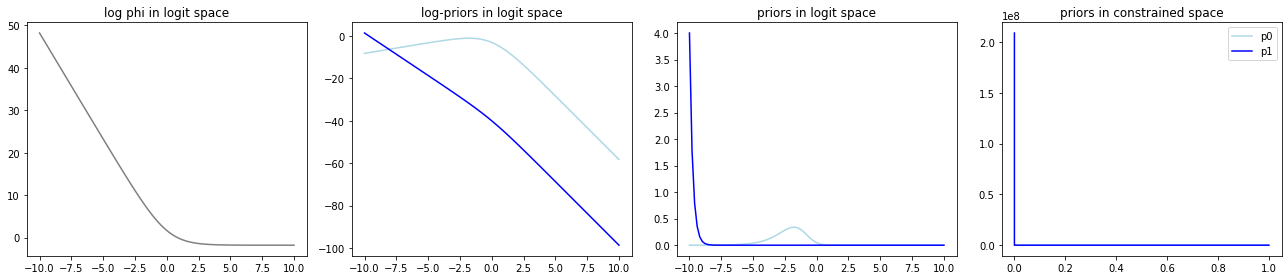

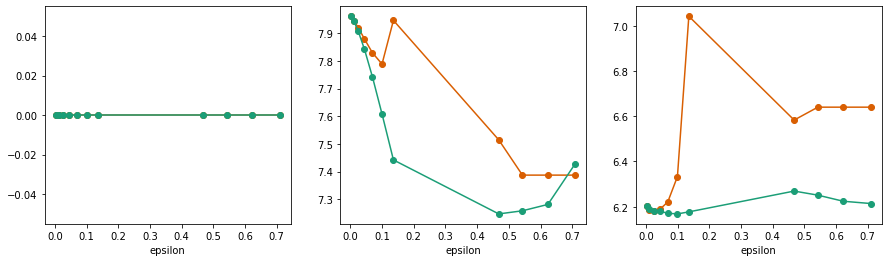

In [114]:
perturbation = 'alpha_pert_neg_xflip'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.227507e-06
  warnings.warn(


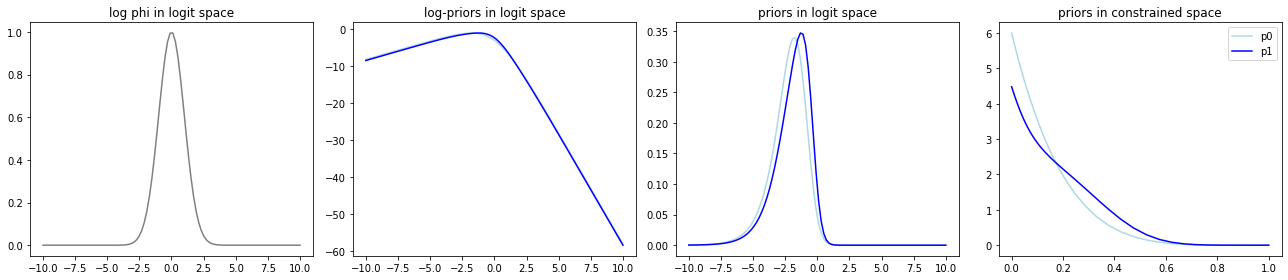

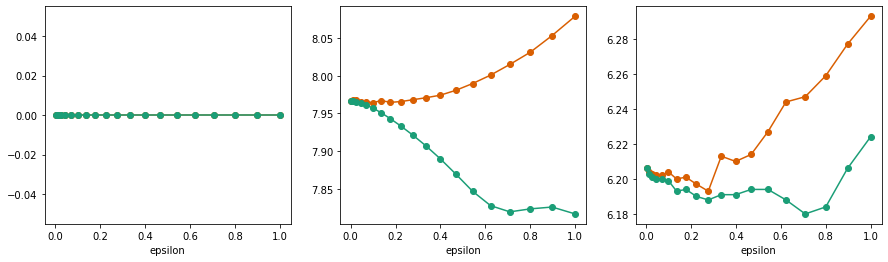

In [115]:
perturbation = 'gauss_pert1_pos'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.001209e-08
  warnings.warn(


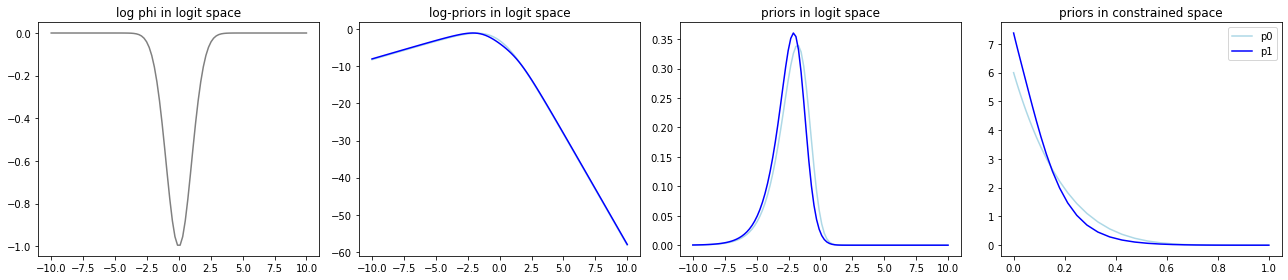

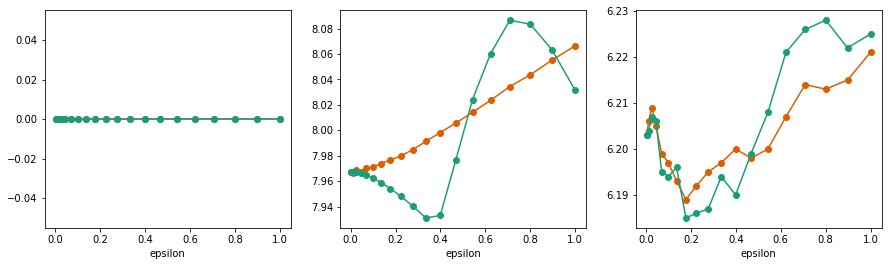

In [116]:
perturbation = 'gauss_pert1_neg'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.412626e-07
  warnings.warn(


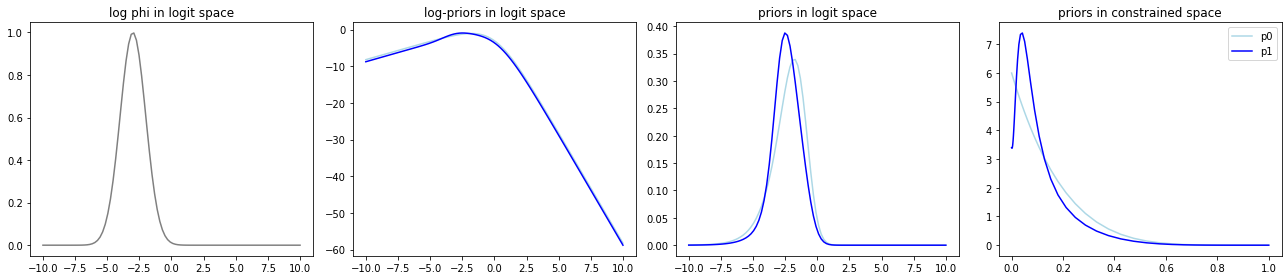

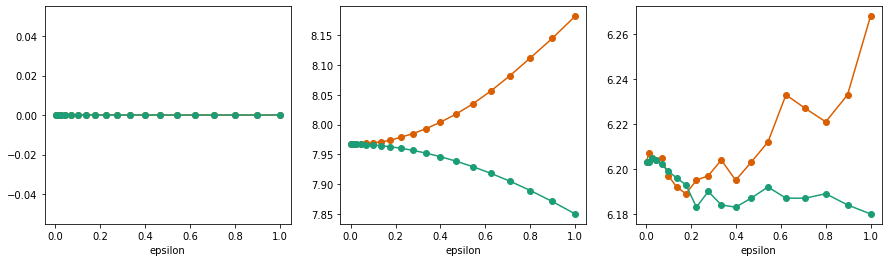

In [117]:
perturbation = 'gauss_pert2_pos'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.524900e-08
  warnings.warn(


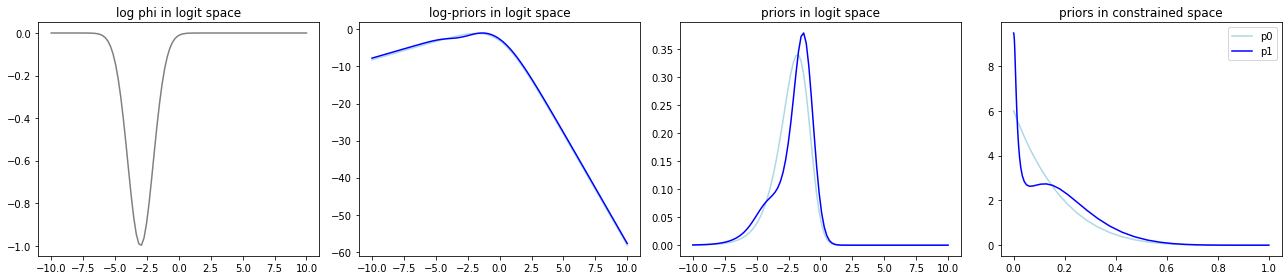

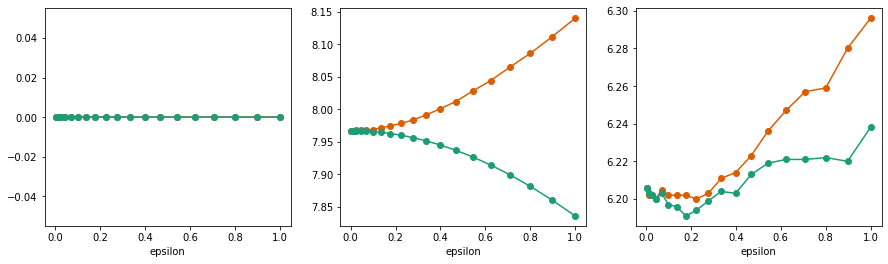

In [118]:
perturbation = 'gauss_pert2_neg'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)